In [54]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
from statsmodels.graphics.tsaplots import plot_acf
import math
import numpy as np
import seaborn as sbs
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib inline 
 
plt.rcParams['figure.figsize']=(8,6)
plt.style.use('ggplot')

In [55]:
base_currency = 'BTC'
#argument needs to be in the form of a string
def get250Day(ticker):
        ''' Acquire historical prices from CRYPTOCOMPARE '''
        url='https://min-api.cryptocompare.com/data/histoday'
        #will return a str
#prices from last 200 days
        parameters= {'fsym':ticker, 'tsym': base_currency, 'e': 'Bittrex', 'aggregate':1,'limit':250}
        
        r=requests.get(url,parameters)
        #handle this error in the calling class
        j_obj=r.json()
        if j_obj['Response']=='Error':
            print(j_obj)
            #print("fetch didn't work")
            raise RuntimeError
        raw_time=j_obj['Data']
        df=pd.DataFrame.from_dict(raw_time)
        df['time']=df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
        df.index=pd.to_datetime(df.time)
        return(df)

In [56]:
mro_df=get250Day('XMR')
mro_df.dtypes

close                float64
high                 float64
low                  float64
open                 float64
time          datetime64[ns]
volumefrom           float64
volumeto             float64
dtype: object

In [57]:
#prepare the dataframe for volatility calc
mro_df['hi_low_log']=mro_df.apply(lambda x: np.log(x['high']/x['low'])**2,axis=1)

In [58]:
mro_df['mid']=mro_df.apply(lambda x: np.mean([x['high'],x['low']]),axis=1)

#### Variable calculation: Rolling mean of length 2, 5, 15 and volatility calculation over past 3 and 15 days
The API pulls daily data

In [59]:
def parkinson(df,window):
    #return(np.log(max(df['high'])/min(df['low']))**2
    return(np.sqrt((1/(4*np.log(2))*sum(df['hi_low_log']))/window))

In [60]:
def rolling_apply(df,window):
    i=np.arange(df.shape[0]+1-window)
    results=np.zeros(df.shape[0])
    for g in i:
        results[g+window-1]=parkinson(df.iloc[g:window+g,],window)
    return(results)

In [61]:
test=rolling_apply(mro_df.iloc[0:5,],3)

In [62]:
mro_df['vol_3day']=rolling_apply(mro_df,3)
mro_df['vol_15day']=rolling_apply(mro_df,15)

In [63]:
#rolling mean
roll_2=mro_df[['mid']].rolling(2).mean()
roll_5=mro_df[['mid']].rolling(5).mean()
roll_15=mro_df[['mid']].rolling(15).mean()

Need to fix column names... then calculate the MA on the daily midpoint.

In [64]:
roll_2.columns=[i+'_MA2' for i in roll_2.columns]
roll_5.columns=[i+'_MA5' for i in roll_5.columns]
roll_15.columns=[i+'_MA15' for i in roll_15.columns]

In [65]:
#concatenate the dataframes
aggd=pd.concat([mro_df,roll_2,roll_5,roll_15],axis=1)

Calculate proportion mid price is above/below the MA prices.

In [66]:
#test=aggd.apply(lambda x: (x[8]/x[11], x[8]/x[12], x[8]/x[13]),axis=1)
test2=aggd.apply(lambda x: x[8]/x[11],axis=1)
test5=aggd.apply(lambda x: x[8]/x[12],axis=1)
test15=aggd.apply(lambda x: x[8]/x[13],axis=1)

In [67]:
test_df=pd.concat([test2,test5,test15],axis=1)
test_df.shape

(251, 3)

In [68]:
var_df=pd.concat([aggd,test_df],axis=1)

In [69]:
lista=[x for x in var_df.columns]
lista[-3:]=['prop2','prop5','prop15']
var_df.columns=lista
var_df['mid_ln']=np.log(var_df['mid'])

### Test for serial correlation among the variables

In [70]:
serials=var_df[['mid','vol_3day','vol_15day','prop2','prop5','prop15']].corr()

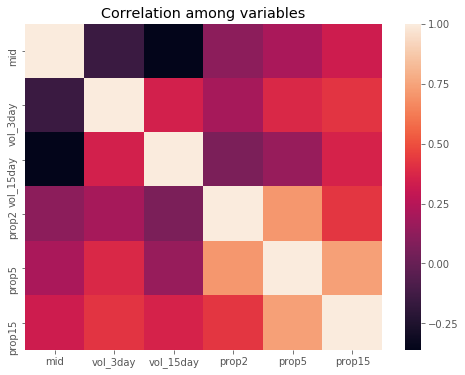

In [71]:
sbs.heatmap(serials)
plt.title('Correlation among variables')
plt.show()

In [72]:
var_df['returns']=var_df['mid'].pct_change()
var_df['ln_diff']=var_df['mid_ln'].diff()
var_df['std_price']=var_df['mid'].rolling(window=21).std()
var_df['std_returns']= var_df['returns'].rolling(window=21).std()

The acf function is part of the statsmodels.graphics.tsaplots module

Plot the price of MRO along with standard deviation of a rolling window.

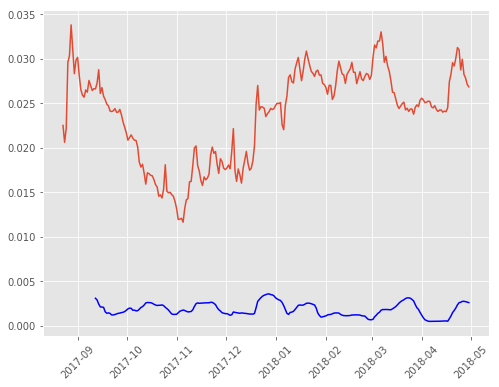

In [73]:
plt.close()
plt.plot(var_df['std_price'],color='blue')
plt.plot(var_df['mid'])
#plt.xticks(mro_df['returns'].index.values)
plt.xticks(rotation=45)
plt.show()

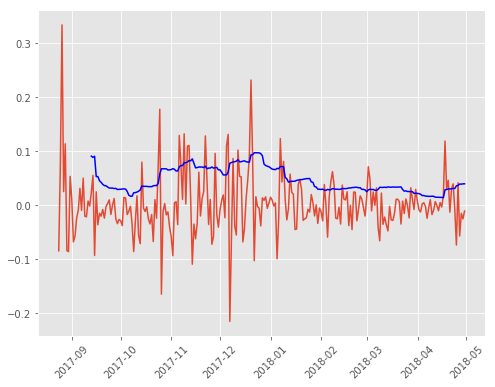

In [74]:
plt.close()
plt.plot(var_df['returns'])
plt.plot(var_df['std_returns'],color='blue')
#plt.xticks(mro_df['returns'].index.values)
plt.xticks(rotation=45)
plt.show()

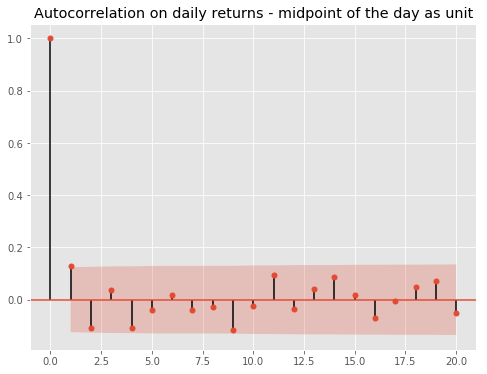

In [75]:
plot_acf(var_df['returns'][1:],lags=20,alpha=.05)
plt.title('Autocorrelation on daily returns - midpoint of the day as unit')
plt.show()

On the above we see the inclusion of confidence intervals around the autocorrelation calculations. Confidence intervals are the bands above and below zero where a statistically significant divergence from 0 cannot be claimed at 95% confidence. This mechanism makes use of the standard normal distribution and calculates the variance with 0 at the mean - 95% of the spread of distribution is contained within 1.96 times the standard deviation. The standard deviation is calculated as 1/sqrt(N)... N = # of observations. What would be interesting is to extract the confidence bands from the plot_acf function to see if the standard deviation and subsequently the N changes with the differing number of observations.

## Model Fitting

The first model we fit is an ARIMA model on the totally untreated data: daily prices of MRO - choose later if we want to include a seasonality order parameter. We arrive at the optimal model via an iterative process fitting permutations of parameter values and selecting the model with the lowest AIC score - a stastic that measures goodness of fit. Keep in mind, this measure uses in-sample data.

In [76]:
p = d = q = range(0, 3)

### Fitting a model using a combination of variables

#### The first algorithm: facebook's fbProphet package
We predict two weeks out at a daily frequency. We will fit the model using the entire datset first. Later, we will fit on a training set, which we will need to isolate and test the model's performance.

In [77]:
import fbprophet

In [78]:
#requires resetting the datetime index and renaming to 'ds', and setting the dependent variable column name to 'y'
fb_version=var_df.rename(columns={'time':'ds','mid':'y'})
ts_prophet=fbprophet.Prophet(changepoint_prior_scale=0.15)
#fb_version.dtypes
fb_version[['y','ds','vol_3day','vol_15day','prop2','prop5','prop15','returns']].head()
ts_prophet.fit(fb_version[['y','ds','vol_3day','vol_15day','prop2','prop5','prop15','returns']])

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [79]:
ts_forecast=ts_prophet.make_future_dataframe(periods=14,freq='D')
ts_forecast=ts_prophet.predict(ts_forecast)

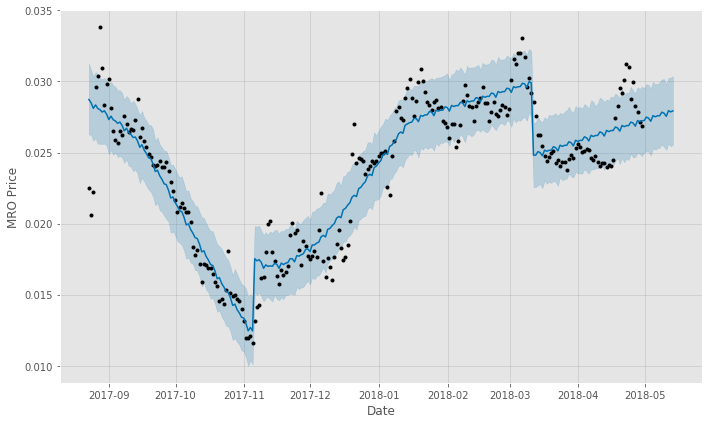

In [80]:
#plot
plt.close()
ts_prophet.plot(ts_forecast,xlabel='Date', ylabel='MRO Price')
plt.show()

The black dots represent the actual values, the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty.

We will refit the above, only this time using logged MRO prices. We will plot the prediction using the exponentiated yhat values, to get the forecasted data back in MRO/BTC units.

In [81]:
fb_version1=var_df.rename(columns={'time':'ds','mid_ln':'y'})
#fb_version.dtypes
ts_prophet1=fbprophet.Prophet(changepoint_prior_scale=0.15)

In [82]:
fb_version1[['y','ds','vol_3day','vol_15day','prop2','prop5','prop15','returns']].head()
ts_prophet1.fit(fb_version1[['y','ds','vol_3day','vol_15day','prop2','prop5','prop15']])
ts_forecast1=ts_prophet1.make_future_dataframe(periods=14,freq='D')
ts_forecast1=ts_prophet1.predict(ts_forecast)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [83]:
ts_forecast1['yhat_exp']=np.exp(ts_forecast1['yhat'])
ts_forecast1['yhat_u_exp']=np.exp(ts_forecast1['yhat_upper'])
ts_forecast1['yhat_l_exp']=np.exp(ts_forecast1['yhat_lower'])

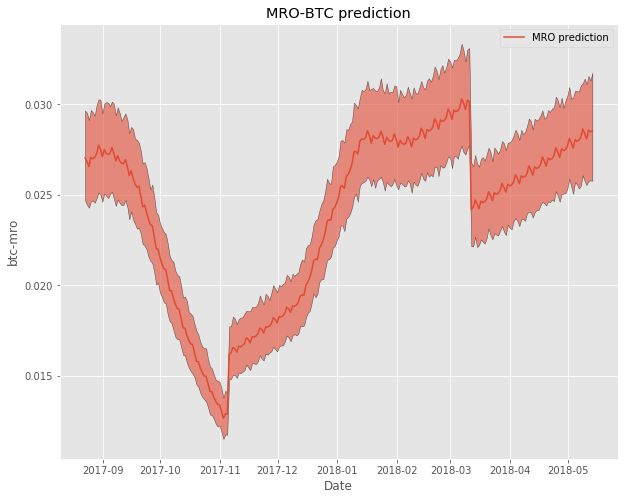

In [84]:
plt.close()
# Create subplots to set figure size
fig, ax = plt.subplots(1, 1, figsize=(10, 8));

# Plot estimate
ax.plot(ts_forecast1['ds'], ts_forecast1['yhat_exp'], label = 'MRO prediction');

# Plot uncertainty values
ax.fill_between(ts_forecast1['ds'].dt.to_pydatetime(), ts_forecast1['yhat_l_exp'], ts_forecast1['yhat_u_exp'], alpha=0.6, edgecolor = 'k');

plt.legend();
plt.xlabel('Date'); plt.ylabel('btc-mro'); plt.title('MRO-BTC prediction');
plt.show()

### Model Accuracy Metrics
We'll rely on two measures: **R-squared and Mean Absolute Error**

It is recommended to create a dataframe of historic values paired with the predicted values - no observations out of sample, where there is no actual/historic data.

source: http://pythondata.com/forecasting-time-series-data-with-prophet-part-1/

In [85]:
#print(mro_df.index[0:5])
test=mro_df[['mid']].join(ts_forecast1.set_index('ds')[['yhat_exp']]).reset_index()
test.dropna(how='any',inplace=True)

In [86]:
r2_score(test.mid, test.yhat_exp)

0.89264852517273841

A pretty damn high R^2, which indicates a likely overfitting.

In [87]:
mean_absolute_error(test.mid, test.yhat_exp)

0.0012231013637508952

## Second ML model: LSTM with Keras

### Model prep: Dataframe transformations
The dataframe will need to have all the inputs (independent variables) relabeled with a t-i format, depending on the lag. Each row must have the dependent at t0 labeled as such and all the independent variables at their historic values on the same row. 

Max-min scalar is applied to all float variables - this is how the variables are normalized.
Explanation of the min-max scalar transform: http://benalexkeen.com/feature-scaling-with-scikit-learn/
Dataframe preparation for a supervised time series model: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Recall we are working with daily data: one observation per day going back 250 days.

In [88]:
#remove any rows with null values or impute zero values
var_df[['mid','vol_3day','vol_15day','prop2','prop5','prop15']]
var_df1=var_df.dropna(how='any')[['mid','vol_3day','vol_15day','prop2','prop5','prop15']]

In [89]:
#the more shifts/lags I apply, the more observations removed from the top (earliest) of the dataset
#will rename each column per the convention provided in the LTSM article... will also need to shift each independent variable
#a function to iteratively append higher rows to later observations
lags=3
temp_df=var_df1.iloc[:,1:]
print(temp_df.shape)
lista=[]
for i in np.arange(1,lags+1,1):
    temp_df=temp_df.shift(-1,axis=0)
    temp_df.columns=['var'+str(counter+1)+'(t-{})'.format(i) for counter, h in enumerate(temp_df.columns)]
    lista.append(temp_df)
agg_df=pd.concat(lista,axis=1)
agg_df['var(t)']=var_df1['mid']

(230, 5)


In [90]:
agg_df.dropna(how='any',inplace=True)
agg_arr=agg_df.values.astype('float32')

The column headers and data is laid out per requirements. Final step is to "normalize" the data... this is done columnwise. 

In [91]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(agg_arr)

In [92]:
df=pd.DataFrame(scaled,columns=agg_df.columns)

Splitting the dataset into a training and testing set. Need to decide on the length of each there are 236 observations in the current dataset at this point.
I'll split at 200 for the test and 36 for the prediction - the reason for this extensive allocation to the training set is the volatile and disparate nature of the price history.

In [106]:
values = df.values
n_train_days = 200
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 1]
test_X, test_y = test[:, 1:], test[:, 1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(200, 1, 15) (200,) (27, 1, 15) (27,)


#### Define and fit the model

Train on 200 samples, validate on 27 samples
Epoch 1/50
 - 2s - loss: 0.3691 - val_loss: 0.0912
Epoch 2/50
 - 0s - loss: 0.3213 - val_loss: 0.0834
Epoch 3/50
 - 0s - loss: 0.2720 - val_loss: 0.0874
Epoch 4/50
 - 0s - loss: 0.2244 - val_loss: 0.1065
Epoch 5/50
 - 0s - loss: 0.1857 - val_loss: 0.1327
Epoch 6/50
 - 0s - loss: 0.1577 - val_loss: 0.1608
Epoch 7/50
 - 0s - loss: 0.1413 - val_loss: 0.1880
Epoch 8/50
 - 0s - loss: 0.1328 - val_loss: 0.2117
Epoch 9/50
 - 0s - loss: 0.1291 - val_loss: 0.2276
Epoch 10/50
 - 0s - loss: 0.1272 - val_loss: 0.2361
Epoch 11/50
 - 0s - loss: 0.1258 - val_loss: 0.2374
Epoch 12/50
 - 0s - loss: 0.1239 - val_loss: 0.2329
Epoch 13/50
 - 0s - loss: 0.1210 - val_loss: 0.2243
Epoch 14/50
 - 0s - loss: 0.1180 - val_loss: 0.2137
Epoch 15/50
 - 0s - loss: 0.1152 - val_loss: 0.2028
Epoch 16/50
 - 0s - loss: 0.1129 - val_loss: 0.1924
Epoch 17/50
 - 0s - loss: 0.1108 - val_loss: 0.1829
Epoch 18/50
 - 0s - loss: 0.1089 - val_loss: 0.1745
Epoch 19/50
 - 0s - loss: 0.

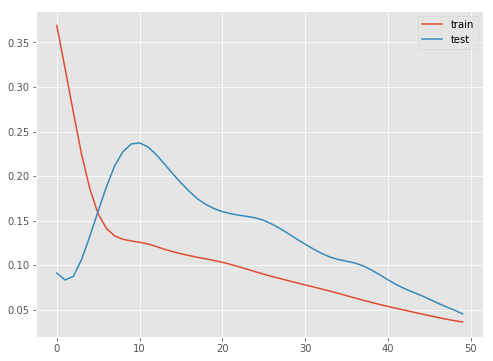

In [107]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network... can play with the batch size and epochs parameters
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Luckily there is little evidence of model overfitting as the training error remains below the test error.

In [108]:
test_X.shape

(27, 1, 15)

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)

In [109]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (27,15) (16,) (27,15) 

### Third Model Artificial Neural Network: Multilayer Perceptron Network

It is stated that LSTM is not appropriate for time series... instead consider MLP with windows: http://dacatay.com/data-science/part-1-time-series-basics-python/

In [ ]:
#print(var_df1.dtypes)
#print(testy.dtypes)

#all dtypes to be converted to float32
var_df1.values.astype('float32')
testy.values.astype('float32')

### When are logs appropriate?
Small changes in the difference of natural logs can be interpreted as percentage changes with a very close approximation. 

In [ ]:
math.log(1.05)

Notice how the difference in the logs of the below are very close to the proportional/percentage difference. In this case we take the difference in logs of two numbers that are 5% apart. Recall that you cannot calculate the natural log of a negative number. One practical application is logging data before fitting a random walk. A logged data set yields a so-called geometric random walk--i.e., a random walk with geometric rather than linear growth. A geometric random walk is the default forecasting model that is commonly used for stock price data.

Because changes in the natural logarithm are (almost) equal to percentage changes in the original series, it follows that the slope of a trend line fitted to logged data is equal to the average percentage growth in the original series. 

resource: https://people.duke.edu/~rnau/411log.htm

In [ ]:
price_chg=mro_df['low'][1:].as_matrix()/mro_df['low'][:-1].as_matrix()
price_chg[0:4]

In [ ]:
price_log=np.log(price_chg)

In [ ]:
plt.close()
plt.plot(price_log)
plt.title('logged returns calculated as day(t) over day(t-1)')
plt.show()

In [ ]:
plt.hist(price_log,bins=25)
plt.show()

In [ ]:
mro_df.head()

In [ ]:
plt.close()
plt.subplot(121)
plt.plot(np.log(mro_df['low'].as_matrix()))
plt.subplot(122)
plt.plot(mro_df['low'])
plt.xticks(rotation=45)
plt.show()

If prices are in logs, then the difference in prices are a good proxy for the percent change in price movement. The difference  in the logs of two different prices is the same as the log ratio of those prices:

math.log(25)-math.log(20) = math.log(25/20)

### Testing for random walk
We make a distinction between a random walk and white noise. A random walk considers the price movement of an asset, while white noise is based on its returns. Today's price is yesterday's price plus some random noise - this is the random walk. White noise on the other hand can be distribution based - whereas deviations from historical returns can be compared to a mathematical/statistical distribution.
Regress prices on a lag price. If the coefficient is not significantly different from 1, then we cannot reject the null hypothesis that it is a random walk. You can also apply a **Dickey-Fuller** test.

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
results=adfuller(mro_df['mid'])
print('the p-value is {}'.format(results[1]))
print('This does not meet the 5% significance level, and so we cannot reject the null hypothesis that prices follow a random walk')

### Stationarity
There is strong form and semi-strong form - where the mean and variance are independent of time. White noise is stationary. Random walk is actually not stationary as the variance increases with time: we know a lot less about the possible values of a series a time far off in the future than we do one nearer in time. Lack of stationarity does not lend itself to modeling as the number of parameters is great to account for the changing nature of the mean and variance. We can make adjustments/transformations to the series to make it stationary. These include a mix of lag differences (appropriate for series with seasonalities) and log transforms to remove trended data.

### Using the autocorr
Autocorrelation tests for correlation of a time series lagging the independent variable. A statistically significant autocorrelation statistic implies the absence of white noise... there is a non-random component to the path of returns. Removing this seasonality from the time series with a diff() application, can turn the series stationary. This can be tested by re-running the autocorr function acf().